In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import seaborn as sn
import xlrd
import operator
import math
import re
import openpyxl
from collections import Counter, defaultdict
from itertools import chain
from decimal import Decimal
from IPython.display import display, HTML
from ast import literal_eval
from pactools.grid_search import GridSearchCVProgressBar

# Sklearn imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn import datasets

import nltk
from nltk.corpus import stopwords
from nltk import bigrams

tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
stemmer = nltk.stem.snowball.SnowballStemmer("dutch")

c:\users\m6800\appdata\local\programs\python\python36\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
c:\users\m6800\appdata\local\programs\python\python36\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
# Importing data
df = pd.read_csv("HandelingenRutte2.csv", index_col=0)
df = df.loc[df['speech category'] == 'Main Speech']
df['stemmed_text'] = df.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(x)]))
df['normal_text'] = df.text.apply(lambda x: ' '.join([t for t in tokenizer.tokenize(x)]))
df.head(5)

,surname,party,text,file,speech category,date,tags,stemmed_text,normal_text
175881,Wilders,PVV,\r\n \r\n Mevrouw de voo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",mevrouw de voorzitter dit kabinet heeft ons mo...,Mevrouw de voorzitter Dit kabinet heeft ons mo...
175882,Roemer,SP,\r\n \r\n Voorzitter. Vo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",voorzitter vorig wek plaatst werkgever werknem...,Voorzitter Vorige week plaatsten werkgevers we...
175883,Pechtold,D66,\r\n \r\n Voorzitter. Tw...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",voorzitter twee maand geled kreg dit kabinet v...,Voorzitter Twee maanden geleden kreeg dit kabi...
175884,Van Haersma Buma,CDA,\r\n \r\n Voorzitter. Al...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",voorzitter allen al in de eerst drie maand van...,Voorzitter Alleen al in de eerste drie maanden...
175889,Thieme,PvdD,\r\n \r\n Voorzitter. We...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",voorzitter we zijn eruit eerst ontdekt de mini...,Voorzitter We zijn eruit Eerst ontdekte de min...


# Data Info

In [3]:
# Creates a dataframe with counts of dataset per party
countdf = df.party.value_counts().sort_index()
with open("Verslag/Tables/Spreekbeurten.tex", "w") as f:
    f.write(countdf.sort_values(ascending=False).to_latex(header=False))
countdf

50PLUS           413
CDA             2216
ChristenUnie    1223
D66             2211
GroenLinks      1193
PVV             1880
PvdA            2269
PvdD             480
SGP              770
SP              2573
VVD             2157
Name: party, dtype: int64

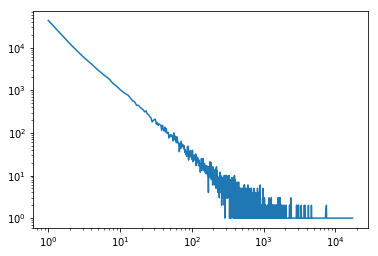

In [4]:
list_text = df.stemmed_text.apply(lambda x: x.split(" "))
tekst = chain.from_iterable([list(set(doc)) for doc in list_text])
count = Counter(tekst)
samples = list(count.values())
t = Counter(samples)
t = sorted(t.items())
x, y = zip(*t)
plt.loglog(x, y)
plt.show()

In [ ]:
t = [len(doc) for doc in list_text]
meanlength = sum(t/len(t))
print(meanlength)
t = Counter(t)
t = sorted(t.items())
x, y = zip(*t)
plt.semilogx(x, y)
plt.show()

# Baseline

In [6]:
simpleprediction = np.random.choice(countdf.index, len(df.party), p = [x/countdf.sum() for x in list(countdf)])
print(classification_report(df.party, simpleprediction))

              precision    recall  f1-score   support

      50PLUS       0.02      0.02      0.02       413
         CDA       0.12      0.12      0.12      2216
ChristenUnie       0.08      0.08      0.08      1223
         D66       0.13      0.13      0.13      2211
  GroenLinks       0.06      0.06      0.06      1193
         PVV       0.10      0.11      0.11      1880
        PvdA       0.12      0.13      0.13      2269
        PvdD       0.03      0.03      0.03       480
         SGP       0.04      0.04      0.04       770
          SP       0.15      0.14      0.14      2573
         VVD       0.13      0.13      0.13      2157

 avg / total       0.11      0.11      0.11     17385



In [7]:
accuracy_score(df.party, np.full(len(df.party), 'SP'))

0.14800115041702616

# Models

In [8]:
def modelsdownload(only_doen=False):
    models_df = pd.read_excel('Models.xlsx', index_col=0)
    if only_doen:
        models_df = models_df.loc[models_df.DOEN == True]
    models_dict = {}
    for x,y in zip(models_df.Classifier, models_df.PIPELINE):
        exec(compile("a="+y,'','exec'), globals())
        models_dict[x] = Pipeline(a)
    return models_df, models_dict

In [9]:
models_df, models_dict = modelsdownload(True)

# Creates a dict with parameters per classifier   
params_dict = {}
for clf in set(models_df.Classifier):
    params_df = models_df.loc[models_df.Classifier == clf]
    params_df = params_df.loc[params_df.DOEN == True]
    params_df = params_df.dropna(axis=1, how='all')
    params_df = params_df.drop([col for col in params_df.columns if "__" not in col], axis=1)
    temp_dict = {}
    for x, y in params_df.to_dict(orient='list').items():
        a = literal_eval(y[0])
        temp_dict[x] = a   
    params_dict[clf] = temp_dict
    
text_dict = {x:y for x, y in zip(models_df.Classifier, models_df.STEMMED)}

In [10]:
scoring = ['accuracy', 'f1_weighted', 'precision_weighted','recall_weighted']
for name, pipe in models_dict.items():
    
    if text_dict[name]:
         text = list(df.normal_text)
    else:
        text = list(df.stemmed_text)
        
    gs = GridSearchCVProgressBar(pipe, params_dict[name], cv=5, scoring=scoring, refit = False, return_train_score = False, n_jobs=1)
    gs.fit(text, df.party)
    rows = pd.DataFrame(gs.cv_results_)
    # https://stackoverflow.com/questions/38231591/splitting-dictionary-list-inside-a-pandas-column-into-separate-columns
    rows = pd.concat([rows.drop(['params'], axis=1), rows['params'].apply(pd.Series)], axis=1)
    rows["name"] = name
    rows["stemmed"] = text_dict[name]
    pd.concat([rows, pd.read_csv('Scores.csv', index_col=0)], ignore_index=True).sort_values(['mean_test_f1_weighted'], ascending=False).to_csv('Scores.csv')
    df4 = pd.read_excel('Models.xlsx', index_col=0)
    df4.loc[df4.Classifier == name, "DOEN"] = False
    df4.to_excel('Models.xlsx')
    print("Voltooid: %s" %name)
    
# https://stackoverflow.com/questions/46735847/save-best-params-in-gridsearch-in-a-pandas-dataframe
# https://stackoverflow.com/questions/36271413/pandas-merge-nearly-duplicate-rows-based-on-column-value?rq=1

# Best Score

In [11]:
# Select the classifier and parameters with highest score
def getbestpipe(file):
    scores = pd.read_csv(file, index_col=0).head(1)
    scores = scores.dropna(axis=1).reset_index(drop=True)
    scores.vect__ngram_range[0] = literal_eval(scores.vect__ngram_range[0])
    models_df, models_dict = modelsdownload(False)
    text_dict = {x:y for x, y in zip(models_df.Classifier, models_df.STEMMED)}
    pipe = models_dict[scores.name[0]]
    params = scores.drop([col for col in scores.columns if "__" not in col or "param" in col], axis=1).to_dict(orient='records')[0]
    params['vect__min_df'] = int(params['vect__min_df'])
    pipe.set_params(**params)
    stem = text_dict[scores.name[0]]
    return pipe, stem
pipe, stem = getbestpipe('Scores.csv')
print(pipe.steps)

[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=None, min_df=5,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=1.0,
        vocabulary=None)), ('SGD', SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5.0, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False))]


c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [12]:
df_train = df.sample(frac=0.8)
df_test_index = list(set(df.index.tolist()) - set(df_train.index.tolist()))
df_test = df[df.index.isin(df_test_index)]
if stem:
    pipe.fit(df_train.stemmed_text, df_train.party)
    predicted = pipe.predict(df_test.stemmed_text)
else:
    pipe.fit(list(df_train.normal_text), list(df_train.party))
    predicted = pipe.predict(df_test.normal_text)
print(classification_report(df_test.party, predicted))

              precision    recall  f1-score   support

      50PLUS       0.96      0.88      0.92        81
         CDA       0.84      0.86      0.85       451
ChristenUnie       0.92      0.82      0.87       233
         D66       0.82      0.85      0.83       451
  GroenLinks       0.92      0.78      0.84       255
         PVV       0.81      0.89      0.85       352
        PvdA       0.81      0.80      0.80       460
        PvdD       0.96      0.91      0.93        85
         SGP       0.89      0.90      0.89       173
          SP       0.78      0.83      0.81       474
         VVD       0.84      0.82      0.83       462

 avg / total       0.84      0.84      0.84      3477



In [13]:
def mostimportantwords(pipe, countdf, filename):
    vocab = pipe.named_steps['vect'].vocabulary_
    inv_vocab = {v: k for k, v in vocab.items()}
    coefs = pipe.named_steps[[x for x in pipe.named_steps.keys() if not x=='vect'][0]].coef_
    top_words = []
    for i in range(coefs.shape[0]):
        temp_list = []
        for t in coefs[i].argsort()[-10:][::-1]:
            temp_list.append(inv_vocab[t])
        top_words.append(temp_list)
    top_words = pd.DataFrame(top_words).T
    top_words.columns = countdf.index
    with open("Verslag/Tables/%s1.tex" %filename, "w") as f:
        f.write(top_words.iloc[:,:5].to_latex(index=False))
    with open("Verslag/Tables/%s2.tex" %filename, "w") as f:
        f.write(top_words.iloc[:,5:].to_latex(index=False))
    return top_words

mostimportantwords(pipe, countdf, 'MostImportantWords')

,50PLUS,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,50plus,cda,de christenunie,d66,groenlink,pvv,de pvda,lid ouwehand nar,sgp,sp,de vvd
1,het lid krol,het cda,christenunie,led van veldhov,lid van tonger,de pvv,pvda,lid ouwehand,de sgp,de sp,vvd
2,lid krol nar,cda fractie,het lid dik,mijn fractie,led van tonger,islamitisch,van de arbeid,het lid ouwehand,led dijkgraf,sp fractie,de vvd is
3,lid krol,de cda fractie,lid dik faber,lid van veldhov,het lid voortman,klever,de arbeid,vor de dier,de led dijkgraf,de sp fractie,vvd is
4,krol nar mij,de cda,lid dik,lid van men,lid voortman,brussel,de partij van,dier,led van der,lid van gerv,vvd fractie
5,krol nar,het lid omtzigt,de led voordewind,d66 is,lid voortman nar,al,partij van de,ouwehand nar mij,sgp fractie,lid smaling nar,de vvd fractie
6,van 50plus,lid omtzigt,led voordewind,d66 wil,de led voortman,nederland,partij van,ouwehand nar,de sgp fractie,lid smaling,vor de vvd
7,krol,lid omtzigt nar,de led dik,van veldhov,led voortman,klever nar mij,arbeid,de dier,led bisschop,het lid smaling,wat de vvd
8,gepensioneerd,led geurt,led dik faber,veldhov,voortman,klever nar,pvda fractie,ouwehand,de led bisschop,smaling,de vvd betreft
9,lid klein nar,de led geurt,led dik,led van men,tonger nar mij,miljard,de pvda fractie,de partij vor,mevrouw de voorzitter,lid leijt,vvd betreft


In [14]:
#source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Echte klasse')
    plt.xlabel('Voorspelde klasse')

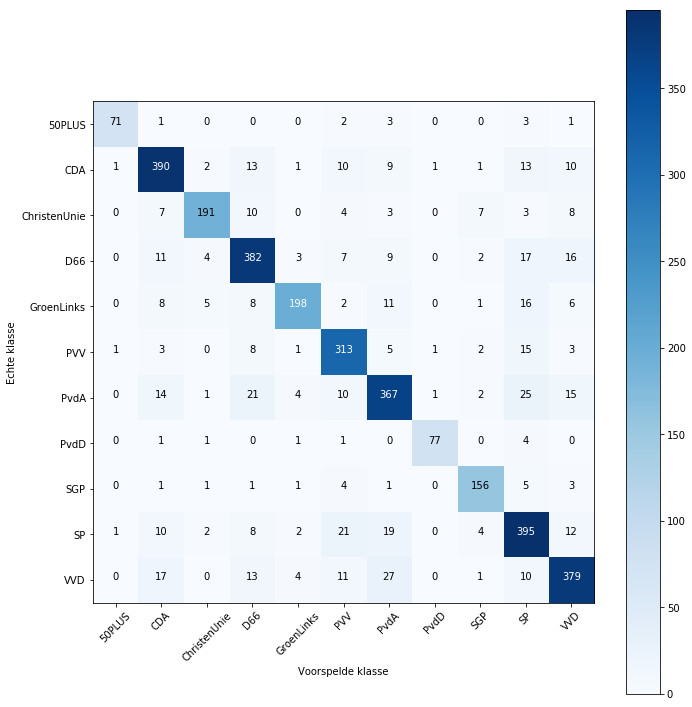

In [15]:
plt.figure(figsize=(10, 10))
cnf_matrix = confusion_matrix(df_test.party, predicted)
plot_confusion_matrix(cnf_matrix, \
                      classes=sorted(list(df.party.unique())), \
                      title='Confusion matrix best estimator')
plt.savefig("Verslag/confusionmatrix.png")
plt.show()

# Without Names

In [43]:
Party_synomyns = ["Partij van de Arbeid","Socialistische Partij","Partij voor de Dieren","Volkspartij voor Vrijheid en Democratie","Partij voor de Vrijheid"]
partijnamen = list(df.party.unique()) + Party_synomyns
partijnamen += ["[Hh]et "+ x for x in partijnamen] + ["[Dd]e "+ x for x in partijnamen]
partijnamen = re.compile('|'.join(partijnamen))
kamerlidnamen = re.compile('|'.join(df.surname.unique()) + "|Dijkstra|Van Dijk|Van Nieuwenhuizen|Baay|Berndsen|Jansen|Günal|Schut|Nijkerken|Buma|Venrooy|Mulder|De Vries|Berckmoes|Van Dijck|Pia")
temp = df.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(re.sub(kamerlidnamen,"xxxxx",re.sub(partijnamen,"yyyyy",x)))]))
df['withoutnames'] = temp.apply(lambda x: (x.replace("xxxxx",'KAMERlIDNAAM')).replace("yyyyy", 'PARTIJNAAM'))
df.head(5)

,surname,party,text,file,speech category,date,tags,stemmed_text,normal_text,withoutnames
175881,Wilders,PVV,\r\n \r\n Mevrouw de voo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",mevrouw de voorzitter dit kabinet heeft ons mo...,Mevrouw de voorzitter Dit kabinet heeft ons mo...,mevrouw de voorzitter dit kabinet heeft ons mo...
175882,Roemer,SP,\r\n \r\n Voorzitter. Vo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",voorzitter vorig wek plaatst werkgever werknem...,Voorzitter Vorige week plaatsten werkgevers we...,voorzitter vorig wek plaatst werkgever werknem...
175883,Pechtold,D66,\r\n \r\n Voorzitter. Tw...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",voorzitter twee maand geled kreg dit kabinet v...,Voorzitter Twee maanden geleden kreeg dit kabi...,voorzitter twee maand geled kreg dit kabinet v...
175884,Van Haersma Buma,CDA,\r\n \r\n Voorzitter. Al...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",voorzitter allen al in de eerst drie maand van...,Voorzitter Alleen al in de eerste drie maanden...,voorzitter allen al in de eerst drie maand van...
175889,Thieme,PvdD,\r\n \r\n Voorzitter. We...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",voorzitter we zijn eruit eerst ontdekt de mini...,Voorzitter We zijn eruit Eerst ontdekte de min...,voorzitter we zijn eruit eerst ontdekt de mini...


In [18]:
pipe, _ = getbestpipe('Scores.csv')
df_train = df.sample(frac=0.8)
df_test_index = list(set(df.index.tolist()) - set(df_train.index.tolist()))
df_test = df[df.index.isin(df_test_index)]
pipe.fit(list(df_train.withoutnames), list(df_train.party))
predicted = pipe.predict(df_test.withoutnames)
print(classification_report(df_test.party, predicted))

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


              precision    recall  f1-score   support

      50PLUS       0.92      0.53      0.68        88
         CDA       0.57      0.60      0.58       431
ChristenUnie       0.70      0.47      0.56       267
         D66       0.54      0.64      0.58       415
  GroenLinks       0.68      0.45      0.54       233
         PVV       0.63      0.75      0.68       357
        PvdA       0.63      0.55      0.59       497
        PvdD       0.79      0.65      0.71       107
         SGP       0.74      0.85      0.79       140
          SP       0.59      0.71      0.64       526
         VVD       0.62      0.60      0.61       416

 avg / total       0.63      0.62      0.62      3477



In [19]:
mostimportantwords(pipe, countdf, 'MostImportantWordsWithoutNames')

,50PLUS,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,gepensioneerd,inwoner,gezinn,mijn fractie,schon energie,islamitisch,kinder,dier,mevrouw de voorzitter,huurder,volgen mij
1,plusser,yyyyy fractie,mensenhandel,natur,zou,nederland,gezamen,de natur,mevrouw de,zegt,yyyyy fractie
2,ouder,yyyyy,inderdad,mijn,schon,miljard,mijn partij,industrie,punt,mens,ondernemer
3,50 plusser,reger,prostitutie,daarom,kamer hierover te,brussel,jonger,dierenwelzijn,wel,de bevolk,yyyyy
4,50,de reger,ook,buitengewon,in elk geval,al,beter,bio industrie,allerlei,bevolk,aangegev
5,ouderenwerklos,hier,amendement,fractie,elk geval,de islam,collega,de bio,je,bezuin,volgen
6,koopkrachtontwikkel,de nederland spoorweg,voedselverspill,hervorm,werkgeleg,islam,wijkverpleegkund,milieu,eenverdiener,segregatie,verzekerar
7,werkend,nederland spoorweg,ik constater,vind,vluchtel,belastingbetaler,tevred,bio,bewindslied,toch,aruba
8,overweg dat,spoorweg,rechtsstat,kans,in elk,asielzoeker,toezegg,klimaatverander,aandacht,armoed,liberal
9,yyyyy,echt,dementie,belangrijk,bewindsperson,natur,die,de bio industrie,nadruk,mening dat,regelgev


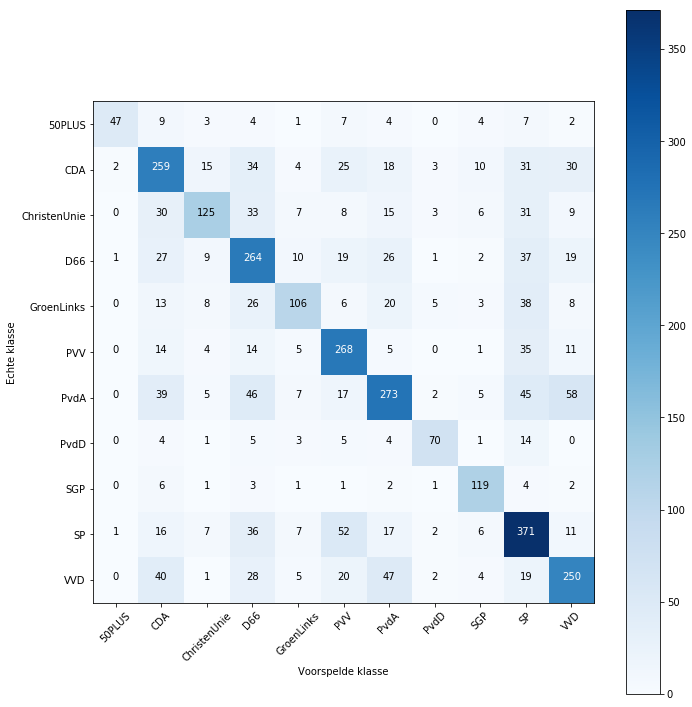

In [20]:
plt.figure(figsize=(10, 10))
cnf_matrix = confusion_matrix(df_test.party, predicted)
plot_confusion_matrix(cnf_matrix, \
                      classes=sorted(list(df.party.unique())), \
                      title='Confusion matrix best estimator')
plt.savefig("Verslag/confusionmatrix2.png")
plt.show()

# Woorden Balkenende 4

In [21]:
# Importing data
dfb4 = pd.read_csv("HandelingenBalkenende4.csv", index_col=0)
dfb4 = dfb4.loc[dfb4['speech category'] == 'Main Speech']
dfb4['stemmed_text'] = dfb4.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(x)]))
dfb4.head(5)

,surname,party,text,file,speech category,date,tags,stemmed_text
5119,Marijnissen,SP,Voorzitter. Wij spreken vandaag voor het eerst...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],voorzitter wij sprek vandag vor het eerst met ...
5135,Van Geel,CDA,Mevrouw de voorzitter. Er is mij gevraagd naar...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],mevrouw de voorzitter er is mij gevraagd nar h...
5191,Rutte,VVD,Mevrouw de voorzitter. Wij voeren vandaag een ...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],mevrouw de voorzitter wij voer vandag een bela...
5238,Tichelaar,PvdA,Mevrouw de voorzitter. Laat ik beginnen met he...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],mevrouw de voorzitter lat ik beginn met het ni...
5275,Wilders,PVV,Mevrouw de voorzitter. Zeer veel dank voor het...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],mevrouw de voorzitter zer vel dank vor het ver...


In [23]:
# Creates a dataframe with counts of dataset per party
countdfb4 = dfb4.party.value_counts().sort_index()
countdfb4

CDA             1348
ChristenUnie     674
D66              623
GroenLinks       901
PVV             1143
PvdA            1204
PvdD             215
SGP              570
SP              1499
VVD             1323
Name: party, dtype: int64

In [44]:
Party_synomyns
partijnamen = list(dfb4.party.unique()) + Party_synomyns
partijnamen += ["[Hh]et "+ x for x in partijnamen] + ["[Dd]e "+ x for x in partijnamen]
partijnamen = re.compile('|'.join(partijnamen))
kamerlidnamen = re.compile('|'.join(dfb4.surname.unique())+"|Kortenhorst|Wiegman|De Roos|Schreijer|Willemse|Snijder|Van Vroonhoven|Dezentjé Hamming|Blanksma|Buma|De Pater|Ortega|Madsen")
temp = dfb4.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(re.sub(kamerlidnamen,"xxxxx",re.sub(partijnamen,"yyyyy",x)))]))
dfb4['withoutnames'] = temp.apply(lambda x: (x.replace("xxxxx",'KAMERlIDNAAM')).replace("yyyyy", 'PARTIJNAAM'))
dfb4.head(5)

,surname,party,text,file,speech category,date,tags,stemmed_text,withoutnames,withoutnames2
5119,Marijnissen,SP,Voorzitter. Wij spreken vandaag voor het eerst...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],voorzitter wij sprek vandag vor het eerst met ...,voorzitter wij sprek vandag vor het eerst met ...,voorzitter wij sprek vandag vor het eerst met ...
5135,Van Geel,CDA,Mevrouw de voorzitter. Er is mij gevraagd naar...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],mevrouw de voorzitter er is mij gevraagd nar h...,mevrouw de voorzitter er is mij gevraagd nar h...,mevrouw de voorzitter er is mij gevraagd nar h...
5191,Rutte,VVD,Mevrouw de voorzitter. Wij voeren vandaag een ...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],mevrouw de voorzitter wij voer vandag een bela...,mevrouw de voorzitter wij voer vandag een bela...,mevrouw de voorzitter wij voer vandag een bela...
5238,Tichelaar,PvdA,Mevrouw de voorzitter. Laat ik beginnen met he...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],mevrouw de voorzitter lat ik beginn met het ni...,mevrouw de voorzitter lat ik beginn met het ni...,mevrouw de voorzitter lat ik beginn met het ni...
5275,Wilders,PVV,Mevrouw de voorzitter. Zeer veel dank voor het...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],mevrouw de voorzitter zer vel dank vor het ver...,mevrouw de voorzitter zer vel dank vor het ver...,mevrouw de voorzitter zer vel dank vor het ver...


In [45]:
pipe, _ = getbestpipe('Scores.csv')
dfb4_train = dfb4.sample(frac=0.8)
dfb4_test_index = list(set(dfb4.index.tolist()) - set(dfb4_train.index.tolist()))
dfb4_test = dfb4[dfb4.index.isin(dfb4_test_index)]
pipe.fit(list(dfb4_train.withoutnames), list(dfb4_train.party))
predicted = pipe.predict(dfb4_test.withoutnames)
print(classification_report(dfb4_test.party, predicted))

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


              precision    recall  f1-score   support

         CDA       0.55      0.63      0.59       251
ChristenUnie       0.74      0.56      0.63       167
         D66       0.75      0.52      0.62       105
  GroenLinks       0.58      0.62      0.60       177
         PVV       0.67      0.69      0.68       241
        PvdA       0.52      0.43      0.47       241
        PvdD       0.55      0.50      0.52        44
         SGP       0.66      0.86      0.75       121
          SP       0.57      0.62      0.60       298
         VVD       0.52      0.52      0.52       255

 avg / total       0.60      0.59      0.59      1900



In [46]:
mostimportantwords(pipe, countdfb4, 'MostImportantWordsWithoutNames')

,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,partijnaam fractie,fractie van partijnaam,patient,partijnaamfractie,vor de vrijheid,vrouw,dier,wel,zegt,partijnaam
1,wij,de fractie van,premier,fractie van partijnaam,partij vor de,wet,dierproev,mijn fractie,mens,onz fractie
2,buitengewon,fractie van,arbeidsmarkt,de fractie,partij vor,groep,bio industrie,helder,bureaucratie,partijnaam fractie
3,fractie,de fractie,hervorm,de fractie van,de partij vor,geweld,de veehouderij,uitdruk,nu,fractie
4,via,moment,europa,premier,burger,volgen mij,dierenwelzijn,allerlei,niet,kamerlidnaamman
5,aangegev,coalitieakkoord,welk,deal,de vrijheid,wij,de bio industrie,toch,lerar,je
6,wij hebb,partijnaamfractie,de arbeidsmarkt,fractie van,de burger,achtergrond,de bio,diver,de bevolk,ondernemer
7,kamerlidnaam,geweest,dadelijk,politiek,natur,iederen,veehouderij,positief,fractie dient,liberal
8,kliniek,mijn fractie,schon energie,mij,niet,all,voorzitter twee,dankzegg vor,verdrag,prat
9,zorgvrager,het coalitieakkoord,hop,van partijnaam,immigratie,medewerker,de natur,dankzegg,ontslag,want


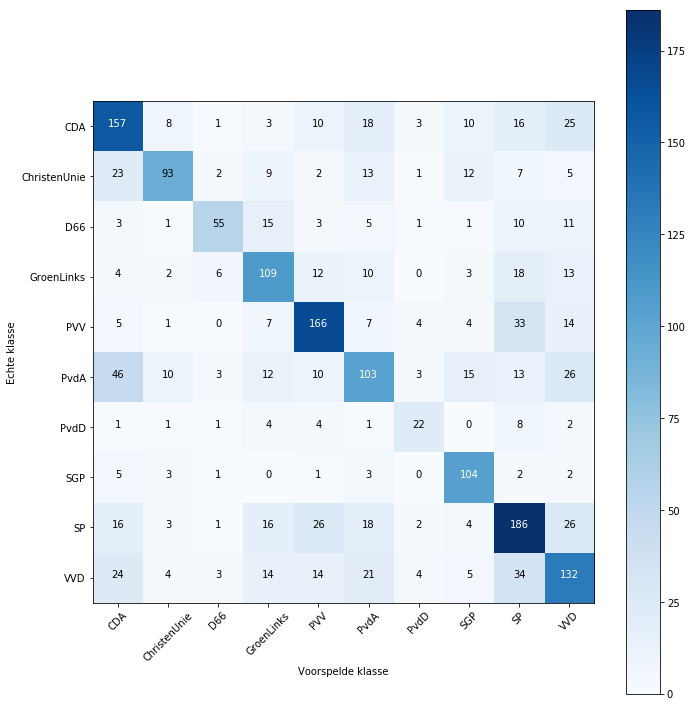

In [47]:
plt.figure(figsize=(10, 10))
cnf_matrix = confusion_matrix(dfb4_test.party, predicted)
plot_confusion_matrix(cnf_matrix, \
                      classes=sorted(list(dfb4.party.unique())), \
                      title='Confusion matrix best estimator')
plt.show()

# Vergelijken

In [50]:
pipe, _ = getbestpipe('Scores.csv')
tempdf = df[df.party != '50PLUS']
pipe.fit(tempdf.withoutnames, tempdf.party)
predicted = pipe.predict(dfb4.withoutnames)
print(classification_report(dfb4.party, predicted))

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


              precision    recall  f1-score   support

         CDA       0.31      0.24      0.27      1348
ChristenUnie       0.46      0.18      0.26       674
         D66       0.20      0.28      0.23       623
  GroenLinks       0.21      0.05      0.08       901
         PVV       0.46      0.66      0.54      1143
        PvdA       0.31      0.37      0.34      1204
        PvdD       0.59      0.54      0.57       215
         SGP       0.48      0.60      0.53       570
          SP       0.44      0.54      0.48      1499
         VVD       0.20      0.19      0.20      1323

 avg / total       0.34      0.36      0.34      9500



In [51]:
pipe, _ = getbestpipe('Scores.csv')
tempdf = df[df.party != '50PLUS']
pipe.fit(dfb4.withoutnames, dfb4.party)
predicted = pipe.predict(tempdf.withoutnames)
print(classification_report(tempdf.party, predicted))

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


              precision    recall  f1-score   support

         CDA       0.22      0.25      0.23      2216
ChristenUnie       0.25      0.17      0.20      1223
         D66       0.24      0.21      0.23      2211
  GroenLinks       0.18      0.09      0.12      1193
         PVV       0.47      0.61      0.53      1880
        PvdA       0.31      0.38      0.34      2269
        PvdD       0.71      0.29      0.41       480
         SGP       0.58      0.42      0.49       770
          SP       0.36      0.55      0.43      2573
         VVD       0.22      0.11      0.15      2157

 avg / total       0.31      0.32      0.31     16972



# Links / Rechts vergelijken

# Git

In [ ]:
!git pull
!git add CompleteNotebook.ipynb
!git add Scraper.ipynb
!git add Scores.csv
!git add Scriptie_Sprekers_TK.pdf
!git add Verslag/Tables/Spreekbeurten.tex
!git add Verslag/Tables/MostImportantWordsWithoutNames1.tex
!git add Verslag/Tables/MostImportantWordsWithoutNames2.tex
!git add Verslag/Tables/MostImportantWords1.tex
!git add Verslag/Tables/MostImportantWords2.tex
!git add Models.xlsx
!git add Verslag/confusionmatrix.png
!git commit -m Update
!git push